In [1]:
import findspark
findspark.init()  

In [2]:
from pyspark.sql.functions import col, sum, when, count, round
import csv
from functools import reduce
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("MyEDA") \
    .master("local[*]") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/18 21:30:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df_spark = spark.read.option("header", True).csv("output/joined_data/part-*.csv")
df_spark.printSchema()
df_spark.show(5)

root
 |-- SEX: string (nullable = true)
 |-- _AGEG5YR: string (nullable = true)
 |-- _IMPRACE: string (nullable = true)
 |-- _LLCPWT: string (nullable = true)
 |-- DIBEV1: string (nullable = true)

+---+--------+--------+-------------+------+
|SEX|_AGEG5YR|_IMPRACE|      _LLCPWT|DIBEV1|
+---+--------+--------+-------------+------+
|2.0|    11.0|     1.0|79.4259469451|     2|
|2.0|    11.0|     1.0|79.4259469451|     2|
|2.0|    11.0|     1.0|79.4259469451|     1|
|2.0|    11.0|     1.0|79.4259469451|     2|
|2.0|    11.0|     1.0|79.4259469451|     2|
+---+--------+--------+-------------+------+
only showing top 5 rows



In [5]:
sample_pd = df_spark.sample(fraction=0.01, seed=42).toPandas()


25/05/18 21:31:02 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
                                                                                

In [6]:
sample_pd

,SEX,_AGEG5YR,_IMPRACE,_LLCPWT,DIBEV1
0,2.0,11.0,1.0,79.4259469451,2
1,2.0,11.0,1.0,79.4259469451,2
2,2.0,11.0,1.0,79.4259469451,2
3,2.0,11.0,1.0,79.4259469451,2
4,1.0,10.0,1.0,89.6945803304,2
...,...,...,...,...,...
2936903,2.0,4.0,5.0,515.7753608445,1
2936904,2.0,1.0,5.0,669.4942064186,2
2936905,2.0,8.0,5.0,291.0447199328,2
2936906,1.0,3.0,5.0,639.9384808379,2


In [7]:
print(df_spark.count())
print(df_spark.printSchema())

[Stage 3:==================================================>      (57 + 7) / 64]

293507839
root
 |-- SEX: string (nullable = true)
 |-- _AGEG5YR: string (nullable = true)
 |-- _IMPRACE: string (nullable = true)
 |-- _LLCPWT: string (nullable = true)
 |-- DIBEV1: string (nullable = true)

None


In [8]:
# Check for null values to make sure data set was merged correctly

null_counts = df_spark.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns])
null_counts.show()

[Stage 6:======================================================>  (61 + 3) / 64]

+---+--------+--------+-------+------+
|SEX|_AGEG5YR|_IMPRACE|_LLCPWT|DIBEV1|
+---+--------+--------+-------+------+
|  0|       0|       0|      0|     0|
+---+--------+--------+-------+------+



## EDA

In [9]:
df_spark.count()
df_spark.groupBy("SEX").count().show()

[Stage 12:====================================================>   (60 + 4) / 64]

+---+---------+
|SEX|    count|
+---+---------+
|1.0|116822724|
|2.0|176685115|
+---+---------+



In [10]:
total_count = df_spark.count()
diabetes_count = df_spark.filter(col("DIBEV1") == 1).count()

print(f"Total records: {total_count}")
print(f"Diabetes cases: {diabetes_count}")
print(f"Prevalence: {diabetes_count / total_count:.2%}")


[Stage 18:===================================================>    (59 + 5) / 64]

Total records: 293507839
Diabetes cases: 34237623
Prevalence: 11.66%


/var/folders/m8/6zt09fhx313d5dk_d202076m0000gn/T/ipykernel_6201/301841959.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




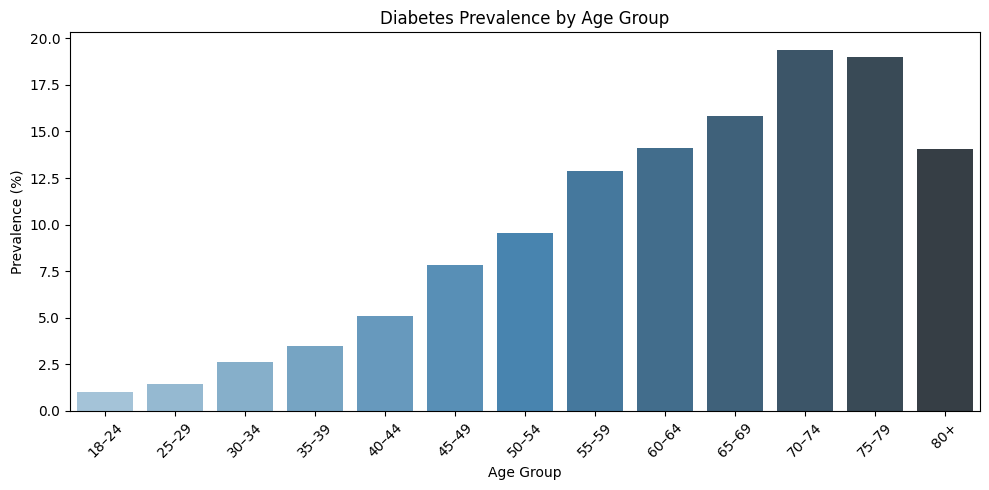

In [7]:
diabetes_by_age = df_spark.groupBy("_AGEG5YR").agg(
    count("*").alias("total"),
    count(when(col("DIBEV1") == 1, True)).alias("diabetes_count")
).withColumn(
    "prevalence", round((col("diabetes_count") / col("total")) * 100, 2)
).orderBy("_AGEG5YR")

df_plot = diabetes_by_age.toPandas()
df_plot["_AGEG5YR"] = df_plot["_AGEG5YR"].astype(float).astype(int)


age_labels = {
    1: "18–24", 2: "25–29", 3: "30–34", 4: "35–39", 5: "40–44",
    6: "45–49", 7: "50–54", 8: "55–59", 9: "60–64", 10: "65–69",
    11: "70–74", 12: "75–79", 13: "80+"
}
df_plot["age_group"] = df_plot["_AGEG5YR"].map(age_labels)

df_plot["age_group"] = pd.Categorical(df_plot["age_group"], ordered=True, categories=age_labels.values())
df_plot = df_plot.sort_values("age_group")

df_plot["age_group"] = pd.Categorical(df_plot["age_group"],
                                      categories=age_labels.values(),
                                      ordered=True)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_plot, x="age_group", y="prevalence", palette="Blues_d")
plt.title("Diabetes Prevalence by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Prevalence (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


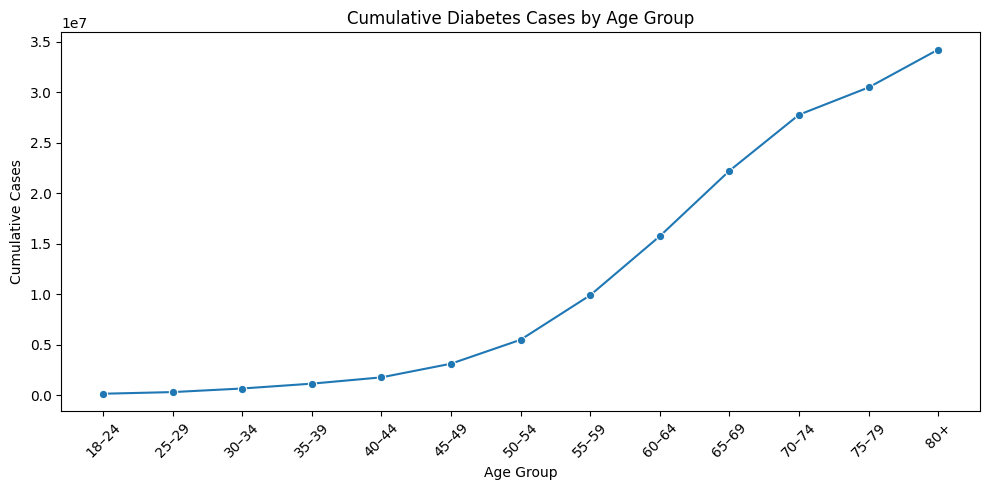

In [12]:
age_cases = df_spark.groupBy("_AGEG5YR").agg(
    count(when(col("DIBEV1") == 1, True)).alias("diabetes_cases")
).orderBy("_AGEG5YR")


df_age_cases = age_cases.toPandas()
df_age_cases["_AGEG5YR"] = df_age_cases["_AGEG5YR"].astype(float).astype(int)

df_age_cases["age_group"] = df_age_cases["_AGEG5YR"].map(age_labels)


df_age_cases = df_age_cases.sort_values("_AGEG5YR")
df_age_cases["cumulative_cases"] = df_age_cases["diabetes_cases"].cumsum()


plt.figure(figsize=(10, 5))
sns.lineplot(data=df_age_cases, x="age_group", y="cumulative_cases", marker="o")
plt.title("Cumulative Diabetes Cases by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Cumulative Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


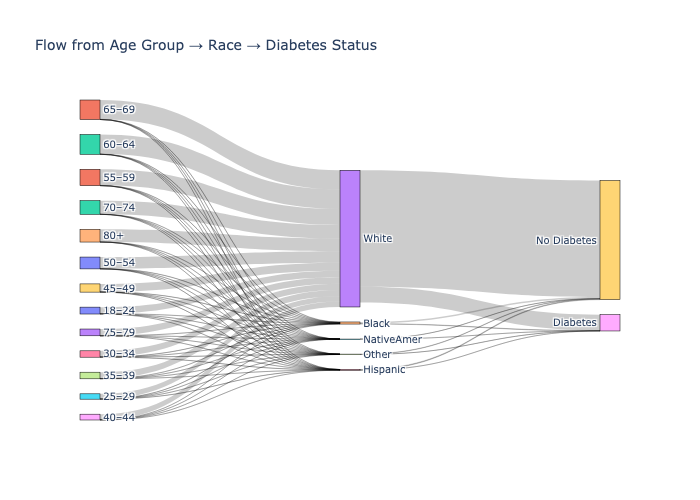

In [8]:
import plotly.io as pio
pio.renderers.default = "png"

grouped = df_spark.groupBy("_AGEG5YR", "_IMPRACE", "DIBEV1").agg(
    count("*").alias("count")
).orderBy("_AGEG5YR", "_IMPRACE", "DIBEV1")

df_flow = grouped.toPandas()


age_labels = {
    1: "18–24", 2: "25–29", 3: "30–34", 4: "35–39", 5: "40–44",
    6: "45–49", 7: "50–54", 8: "55–59", 9: "60–64", 10: "65–69",
    11: "70–74", 12: "75–79", 13: "80+"
}
race_labels = {
    1.0: "White", 2.0: "Black", 3.0: "Asian", 4.0: "NativeAmer",
    5.0: "Hispanic", 6.0: "Other"
}
diab_labels = {1.0: "Diabetes", 2.0: "No Diabetes"}

df_flow["_AGEG5YR"] = df_flow["_AGEG5YR"].astype(float).astype(int)
df_flow["_IMPRACE"] = df_flow["_IMPRACE"].astype(float)
df_flow["DIBEV1"] = df_flow["DIBEV1"].astype(float)


df_flow["age"] = df_flow["_AGEG5YR"].map(age_labels)
df_flow["race"] = df_flow["_IMPRACE"].map(race_labels)
df_flow["diabetes"] = df_flow["DIBEV1"].map(diab_labels)


labels = list(df_flow["age"].unique()) + list(df_flow["race"].unique()) + list(df_flow["diabetes"].unique())
label_map = {label: i for i, label in enumerate(labels)}


links = []


for _, row in df_flow.groupby(["age", "race"])["count"].sum().reset_index().iterrows():
    links.append(dict(
        source=label_map[row["age"]],
        target=label_map[row["race"]],
        value=row["count"]
    ))

for _, row in df_flow.groupby(["race", "diabetes"])["count"].sum().reset_index().iterrows():
    links.append(dict(
        source=label_map[row["race"]],
        target=label_map[row["diabetes"]],
        value=row["count"]
    ))

fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=[l["source"] for l in links],
        target=[l["target"] for l in links],
        value=[l["value"] for l in links]
    )
))

fig.update_layout(title_text="Flow from Age Group → Race → Diabetes Status", font_size=10)
fig.show()


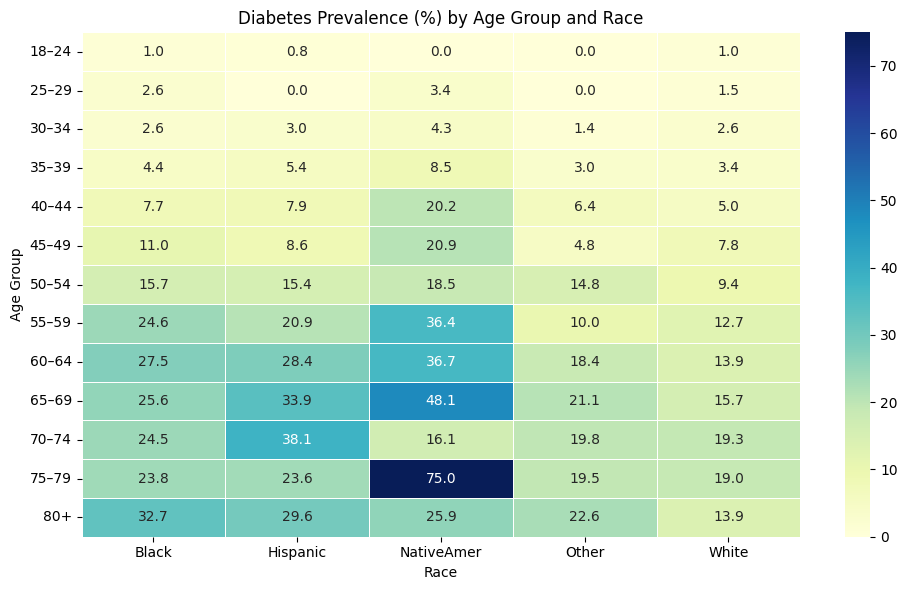

In [49]:
heatmap_df = df_spark.groupBy("_AGEG5YR", "_IMPRACE").agg(
    count("*").alias("total"),
    count(when(col("DIBEV1") == 1, True)).alias("diabetes_count")
).withColumn(
    "prevalence", round((col("diabetes_count") / col("total")) * 100, 2)
)

df_heat = heatmap_df.toPandas()

df_heat["_AGEG5YR"] = df_heat["_AGEG5YR"].astype(float).astype(int)
df_heat["_IMPRACE"] = df_heat["_IMPRACE"].astype(float)


df_heat["age_group"] = df_heat["_AGEG5YR"].map(age_labels)
df_heat["race"] = df_heat["_IMPRACE"].map(race_labels)

heatmap_matrix = df_heat.pivot(index="age_group", columns="race", values="prevalence")
heatmap_matrix = heatmap_matrix.reindex(age_labels.values())  # Keep age order

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_matrix, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title("Diabetes Prevalence (%) by Age Group and Race")
plt.xlabel("Race")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()


## Logistic Regression and Random Forest Diabetes Predictors

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col

sex_idx   = StringIndexer( inputCol="SEX",      outputCol="sex_idx" )
age_idx   = StringIndexer( inputCol="_AGEG5YR", outputCol="age_idx" )
race_idx  = StringIndexer( inputCol="_IMPRACE", outputCol="race_idx" )

encoder = OneHotEncoder(
    inputCols=["sex_idx","age_idx","race_idx"],
    outputCols=["sex_vec","age_vec","race_vec"]
)

assembler = VectorAssembler(
    inputCols=["sex_vec","age_vec","race_vec","_LLCPWT"],
    outputCol="features"
)

lr = LogisticRegression(
    featuresCol="features",
    labelCol="diabetes_label",   
    weightCol="_LLCPWT",
    maxIter=10
)

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="diabetes_label",  
    weightCol="_LLCPWT",
    numTrees=20,
    maxDepth=5
)

pipe_lr = Pipeline(stages=[sex_idx, age_idx, race_idx, encoder, assembler, lr])
pipe_rf = Pipeline(stages=[sex_idx, age_idx, race_idx, encoder, assembler, rf])


df_clean = (df_spark
    .withColumn("_LLCPWT",    col("_LLCPWT").cast("double"))
    .withColumn("diabetes_label",
                when(col("DIBEV1")==1, 1).otherwise(0).cast("int"))
    .dropna(subset=["SEX", "_AGEG5YR", "_IMPRACE", "_LLCPWT", "diabetes_label"])
)


In [21]:
sample_df = df_clean.sample(0.1, seed=42)
train, test = sample_df.randomSplit([0.8, 0.2], seed=42)

model_lr = pipe_lr.fit(train)
model_rf = pipe_rf.fit(train)

pred_lr = model_lr.transform(test)
pred_rf = model_rf.transform(test)

evaluator_auc = BinaryClassificationEvaluator(
    labelCol="diabetes_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="diabetes_label", predictionCol="prediction", metricName="accuracy"
)

for name, preds in [("LogisticRegression", pred_lr), ("RandomForest", pred_rf)]:
    auc = evaluator_auc.evaluate(preds)
    acc = evaluator_acc.evaluate(preds)
    print(f"{name}: AUC = {auc:.3f}, Accuracy = {acc:.3f}")

25/05/18 20:06:20 WARN MemoryStore: Not enough space to cache rdd_430_8 in memory! (computed 17.0 MiB so far)
25/05/18 20:06:20 WARN BlockManager: Persisting block rdd_430_8 to disk instead.
25/05/18 20:06:20 WARN MemoryStore: Not enough space to cache rdd_430_13 in memory! (computed 17.0 MiB so far)
25/05/18 20:06:20 WARN BlockManager: Persisting block rdd_430_13 to disk instead.
25/05/18 20:06:20 WARN MemoryStore: Not enough space to cache rdd_430_12 in memory! (computed 17.0 MiB so far)
25/05/18 20:06:20 WARN BlockManager: Persisting block rdd_430_12 to disk instead.
25/05/18 20:06:27 WARN MemoryStore: Not enough space to cache rdd_430_18 in memory! (computed 17.0 MiB so far)
25/05/18 20:06:27 WARN MemoryStore: Not enough space to cache rdd_430_22 in memory! (computed 17.0 MiB so far)
25/05/18 20:06:27 WARN BlockManager: Persisting block rdd_430_18 to disk instead.
25/05/18 20:06:27 WARN BlockManager: Persisting block rdd_430_22 to disk instead.
25/05/18 20:06:27 WARN MemoryStore: N

LogisticRegression: AUC = 0.668, Accuracy = 0.883


[Stage 217:===================================================>   (60 + 4) / 64]

RandomForest: AUC = 0.597, Accuracy = 0.883


We trained two classifiers using only demographic features (sex, age group, race) and the survey weight `_LLCPWT`:

| Model              | AUC   | Accuracy |
|-------------------|-------|----------|
| Logistic Regression | 0.668 | 0.883    |
| Random Forest       | 0.597 | 0.883    |

- **Logistic Regression** outperformed the Random Forest in terms of AUC, indicating better discrimination between diabetic and non-diabetic individuals, even though both models achieved the same accuracy.
- The high accuracy is likely driven by class imbalance, so **AUC is the more informative metric** in this case.